In [3]:
import torch
#import torch_directml
import torch.nn.functional as F
import matplotlib.pyplot as plt

from network import Network
from data import get_MNIST_data_loaders
from train import train_network
from evaluate import accuracy

import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

variant = "l"
batch_size = 256

train_loader, test_loader = get_MNIST_data_loaders(batch_size, variant=variant)

device=device(type='cpu')


In [5]:
def accuracy_with_noise(model, data_loader, eps, variant="p", device=None):
    with torch.no_grad():
        correct, total = 0, 0
        for x, label in data_loader:
            x = reshape_image(x, variant=variant).to(device)
            label = label.to(device)

            # add noise
            z = torch.randn(x.shape)
            z = z / z.norm(dim=(1,2)).reshape(z.shape[0], 1, 1)
            x = x + eps * z

            # sequentially send input into network
            model.reset(x.shape[0])
            for i in range(x.shape[1]):
                model(x[:, i, :])

            pred_y = model(model.zero_input(x.shape[0]))
            pred = F.softmax(pred_y, dim=1) # add softmax
            correct += torch.sum(torch.argmax(pred, dim=1) == label)
            total += x.shape[0]
        acc = correct / total
    return acc.item()

def reshape_image(x, variant="p"):
    if variant == "p":
        x = x.reshape(x.shape[0], 24, 24)
        return x.reshape(x.shape[0], -1, 1)
    else:
        return x.reshape(x.shape[0], 28, 28)

def load_network(fname):
    state = torch.load(fname)
    print(state.keys())
    model = Network(
        1 if state["variant"] == "p" else 28, 
        state["hidden_dim"], 
        10,
        freeze_neurons=state["freeze_neurons"], 
        freeze_g=state["freeze_activations"]
    )
    model.load_state_dict(state["model_state_dict"])
    return model

def load_rnn(fname, lstm=False):
    state = torch.load(fname)
    model = RNN(
        1 if state["variant"] == "p" else 28, 
        state["hidden_dim"], 
        10,
        lstm=lstm
    )
    model.load_state_dict(state["model_state_dict"])
    return model

def permuted_network(fname, variant, n_neurons):
    model = load_network(fname)

    in_dim = model.in_dim
    hidden_dim = model.hidden_dim
    out_dim = model.out_dim
    
    new_model = Network(
        in_dim, 
        hidden_dim, 
        out_dim,
        freeze_neurons=True, 
        freeze_g=True
    )

    idxs = (np.random.rand(n_neurons) * n_neurons).astype(int)
    new_model.hidden_neurons.g.max_current = torch.nn.Parameter(model.hidden_neurons.g.max_current.detach().clone()[idxs], requires_grad=False)
    new_model.hidden_neurons.g.max_firing_rate = torch.nn.Parameter(model.hidden_neurons.g.max_firing_rate.detach().clone()[idxs], requires_grad=False)
    new_model.hidden_neurons.g.max_firing_rate = torch.nn.Parameter(model.hidden_neurons.g.max_firing_rate.detach().clone()[idxs], requires_grad=False)
    new_model.hidden_neurons.g.b = torch.nn.Parameter(model.hidden_neurons.g.b.detach().clone()[idxs], requires_grad=False)
    new_model.hidden_neurons.g.poly_coeff = torch.nn.Parameter(model.hidden_neurons.g.poly_coeff.detach().clone()[idxs], requires_grad=False)
    new_model.hidden_neurons.a = torch.nn.Parameter(model.hidden_neurons.a.detach().clone()[idxs, :], requires_grad=False)
    new_model.hidden_neurons.b = torch.nn.Parameter(model.hidden_neurons.b.detach().clone()[idxs, :], requires_grad=False)

    return new_model

def get_losses(fname):
    state = torch.load(fname)
    return state["losses"]

In [6]:
class RNN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, lstm=False, device=None):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        if lstm:
            self.rnn = torch.nn.LSTM(in_dim, hidden_dim)
        else:
            self.rnn = torch.nn.RNN(in_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, out_dim)
        self.device = device
        self.lstm = lstm

    def reset(self, batch_size):
        self.xh = torch.zeros(1, batch_size, self.hidden_dim).to(self.device)
        if self.lstm:
            self.xc = torch.zeros(1, batch_size, self.hidden_dim).to(self.device)
        
    def zero_input(self, batch_size):
        return torch.zeros(batch_size, self.in_dim).to(self.device)
        
    def forward(self, x):
        if self.lstm:
            z, (self.xh, self.xc) = self.rnn(x.unsqueeze(dim=0), (self.xh, self.xc))
        else:
            z, self.xh = self.rnn(x.unsqueeze(dim=0), self.xh)
        return self.fc(z.reshape(x.shape[0], self.hidden_dim))

In [11]:
model = load_network("model/network_params/l_64_False_True.pt")

dict_keys(['model_state_dict', 'train_accuracy', 'test_accuracy', 'lr', 'epochs', 'hidden_dim', 'variant', 'freeze_neurons', 'freeze_activations'])


In [32]:
model = load_rnn("model/network_params/l_64_rnn.pt", lstm=False)

In [30]:
def get_accs_with_noise(model, dataloader, eps, trials, variant="l"):
    accs = []
    for _ in range(trials):
        acc = accuracy_with_noise(model, dataloader, eps, variant=variant)
        accs.append(acc)
    return accs

def get_accs_with_noise_epss(model, dataloader, epss, trials, variant="l"):
    accss = {}
    for eps in epss:
        print(eps)
        accss[eps] = get_accs_with_noise(model, dataloader, eps, trials, variant=variant)
    return accss

dict_keys(['model_state_dict', 'train_accuracy', 'test_accuracy', 'lr', 'epochs', 'hidden_dim', 'variant', 'freeze_neurons', 'freeze_activations'])
0.0
1.1111111111111112
2.2222222222222223
3.3333333333333335
4.444444444444445
5.555555555555555
6.666666666666667
7.777777777777779
8.88888888888889
10.0
0.0
1.1111111111111112
2.2222222222222223
3.3333333333333335
4.444444444444445
5.555555555555555
6.666666666666667
7.777777777777779
8.88888888888889
10.0


Text(0, 0.5, 'test accuracy')

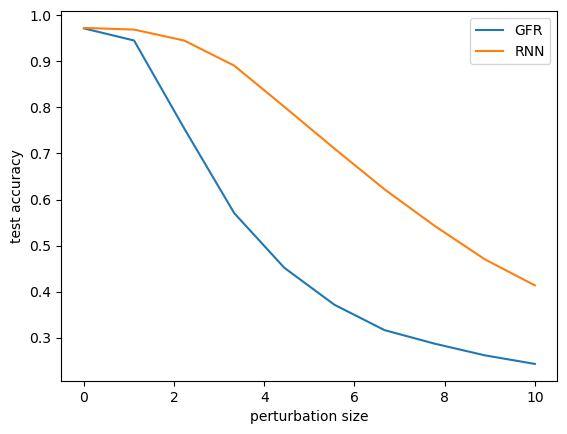

In [35]:
model = load_network("model/network_params/l_64_False_True.pt")

epss = np.linspace(0, 10, 10)
trials = 1
#train_accss = get_accs_with_noise_epss(model, train_loader, epss, trials, variant=variant)
test_accss = get_accs_with_noise_epss(model, test_loader, epss, trials, variant=variant)

#mean_train_accss = [np.mean(train_accss[e]) for e in train_accss]
mean_test_accss = [np.mean(test_accss[e]) for e in test_accss]

#plt.plot(epss, mean_train_accss)
plt.plot(epss, mean_test_accss, label="GFR")

model = load_rnn("model/network_params/l_64_rnn.pt", lstm=False)

#train_accss = get_accs_with_noise_epss(model, train_loader, epss, trials, variant=variant)
test_accss = get_accs_with_noise_epss(model, test_loader, epss, trials, variant=variant)

#mean_train_accss = [np.mean(train_accss[e]) for e in train_accss]
mean_test_accss = [np.mean(test_accss[e]) for e in test_accss]

plt.plot(epss, mean_test_accss, label="RNN")
plt.legend()
plt.xlabel("perturbation size")
plt.ylabel("test accuracy")

In [20]:
in_dim = 1 if variant == "p" else 28
hidden_dim = 68#64
out_dim = 10
lr = 1e-3
epochs = 10
freeze_neurons = False
freeze_activations = True

In [22]:
model = RNN(in_dim, hidden_dim, out_dim, lstm=False)

In [9]:
if freeze_neurons:
    model = permuted_network(f"model/network_params/gfr_{variant}_{hidden_dim}_False_True.pt", variant, hidden_dim)
else:
    model = Network(
        in_dim, 
        hidden_dim, 
        out_dim,
        freeze_neurons=freeze_neurons, 
        freeze_g=freeze_activations
    )

In [23]:
sum(p.numel() for p in filter(lambda x: x.requires_grad, model.parameters()))

7354

In [ ]:
train_network(
    model, 
    train_loader, 
    epochs=10, 
    lr=lr,
    variant=variant,
)

tensor(2.3336, grad_fn=<DivBackward1>)
tensor(2.3935, grad_fn=<DivBackward1>)
tensor(2.3608, grad_fn=<DivBackward1>)
tensor(2.2578, grad_fn=<DivBackward1>)
tensor(2.4906, grad_fn=<DivBackward1>)
tensor(2.3783, grad_fn=<DivBackward1>)
tensor(2.3612, grad_fn=<DivBackward1>)
tensor(2.3588, grad_fn=<DivBackward1>)
tensor(2.2875, grad_fn=<DivBackward1>)
tensor(2.2684, grad_fn=<DivBackward1>)
tensor(2.3406, grad_fn=<DivBackward1>)
tensor(2.3786, grad_fn=<DivBackward1>)
tensor(2.4708, grad_fn=<DivBackward1>)
tensor(2.3051, grad_fn=<DivBackward1>)
tensor(2.2906, grad_fn=<DivBackward1>)
tensor(2.3209, grad_fn=<DivBackward1>)
tensor(2.2326, grad_fn=<DivBackward1>)
tensor(2.2982, grad_fn=<DivBackward1>)
tensor(2.2628, grad_fn=<DivBackward1>)
tensor(2.4410, grad_fn=<DivBackward1>)
tensor(2.3162, grad_fn=<DivBackward1>)
tensor(2.2668, grad_fn=<DivBackward1>)
tensor(2.4150, grad_fn=<DivBackward1>)
tensor(2.2434, grad_fn=<DivBackward1>)
tensor(2.3336, grad_fn=<DivBackward1>)
tensor(2.2802, grad_fn=<D

In [ ]:
train_acc = accuracy(model, train_loader, variant=variant, device=device)
test_acc = accuracy(model, test_loader, variant=variant, device=device)
print(f"Train accuracy: {train_acc} | Test accuracy: {test_acc}")

In [ ]:
sum(p.numel() for p in filter(lambda x: x.requires_grad, model.parameters()))

In [ ]:
torch.save(
    {
        "model_state_dict": model.to(torch.device("cpu")).state_dict(),
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "lr": lr,
        "epochs": epochs,
        "hidden_dim": hidden_dim,
        "variant": variant,
        "freeze_neurons": freeze_neurons,
        "freeze_activations": freeze_activations
    },
    f"model/network_params/{variant}_{hidden_dim}_{freeze_neurons}_{freeze_activations}.pt"
)

In [ ]:
torch.save(
    {
        "model_state_dict": model.to(torch.device("cpu")).state_dict(),
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "lr": lr,
        "epochs": epochs,
        "hidden_dim": hidden_dim,
        "variant": variant,
        "freeze_neurons": freeze_neurons,
        "freeze_activations": freeze_activations
    },
    f"model/network_params/{variant}_{hidden_dim}_rnn.pt"
)

In [ ]:
torch.save(
    {
        "model_state_dict": model.to(torch.device("cpu")).state_dict(),
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "lr": lr,
        "epochs": epochs,
        "hidden_dim": hidden_dim,
        "variant": variant,
        "freeze_neurons": freeze_neurons,
        "freeze_activations": freeze_activations
    },
    f"model/network_params/{variant}_{hidden_dim}_lstm.pt"
)

In [7]:
gfr_loss = get_losses("model/network_params/gfr_l_64_False_True.pt")
rnn_loss = get_losses("model/network_params/rnn_l_68_False_True.pt")

In [9]:
import numpy as np

Text(0, 0.5, 'log train loss')

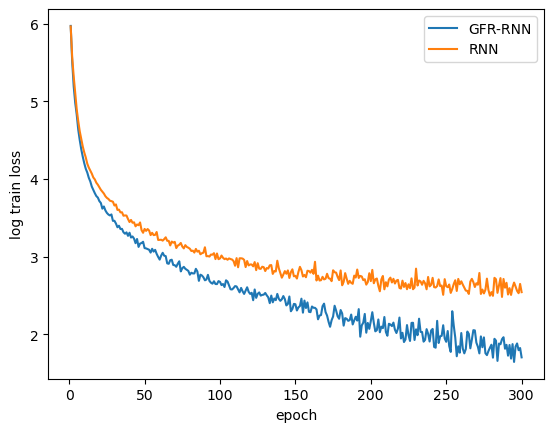

In [11]:
epochs = len(gfr_loss)
xs = np.arange(1, epochs+1)
plt.plot(xs, np.log(gfr_loss), label="GFR-RNN")
plt.plot(xs, np.log(rnn_loss), label="RNN")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("log train loss")

In [13]:
gfr = load_network("model/network_params/gfr_l_64_False_True.pt")

dict_keys(['model_state_dict', 'train_accuracy', 'test_accuracy', 'lr', 'epochs', 'hidden_dim', 'variant', 'freeze_neurons', 'freeze_activations', 'losses'])


RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_neurons.ds: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for hidden_neurons.a: copying a param with shape torch.Size([64, 4]) from checkpoint, the shape in current model is torch.Size([64, 6]).
	size mismatch for hidden_neurons.b: copying a param with shape torch.Size([64, 4]) from checkpoint, the shape in current model is torch.Size([64, 6]).